In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os

from utils import *

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "energy-functions-only"  # e.g., your project name
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)
take_x_seeds = 5

In [4]:
exp_names = [
    "ant_l_symmetric_infonce_ef_l1",
    "ant_l_symmetric_infonce_ef_l2",
    "ant_l_symmetric_infonce_ef_l2_no_sqrt",
    "ant_l_symmetric_infonce_ef_dot",
    "ant_l_symmetric_infonce_ef_cos",
]

exp_names_mapping = {
    "ant_l_symmetric_infonce_ef_l1": "L1",
    "ant_l_symmetric_infonce_ef_l2": "L2",
    "ant_l_symmetric_infonce_ef_l2_no_sqrt": "L2 w/o sqrt",
    "ant_l_symmetric_infonce_ef_dot": "Dot",
    "ant_l_symmetric_infonce_ef_cos": "Cos",
}

In [5]:
env_title_mapping = {
    "ant_ball": "Ant Soccer",
    "ant": "Ant",
    "ant_big_maze": "Ant Big Maze",
    "ant_u_maze": "Ant U-Maze",
}
metric_to_metric_label_dict = {
    "eval/episode_success": "Time in goal proximity",
    "eval/episode_success_any": "Success rate",
}

# Results for all envs

In [6]:
metrics_ = ["eval/episode_success_any", "eval/episode_success"]
single_env=False


In [7]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [8]:
len(runs)

189

L1, Ant Soccer
(5, 1, 50)
L2, Ant Soccer
(5, 1, 50)
L2 w/o sqrt, Ant Soccer
(5, 1, 50)
Dot, Ant Soccer
(5, 1, 50)
Cos, Ant Soccer
(5, 1, 50)
L1, Ant
(5, 1, 50)
L2, Ant
(5, 1, 50)
L2 w/o sqrt, Ant
(5, 1, 50)
Dot, Ant
(5, 1, 50)
Cos, Ant
(5, 1, 50)
L1, Ant Big Maze
(5, 1, 50)
L2, Ant Big Maze
(5, 1, 50)
L2 w/o sqrt, Ant Big Maze
(5, 1, 50)
Dot, Ant Big Maze
(5, 1, 50)
Cos, Ant Big Maze
(5, 1, 50)
L1, Ant U-Maze
(5, 1, 50)
L2, Ant U-Maze
(5, 1, 50)
L2 w/o sqrt, Ant U-Maze
(5, 1, 50)
Dot, Ant U-Maze
(5, 1, 50)
Cos, Ant U-Maze
(5, 1, 50)
L1, Ant Soccer
(5, 1, 50)
L2, Ant Soccer
(5, 1, 50)
L2 w/o sqrt, Ant Soccer
(5, 1, 50)
Dot, Ant Soccer
(5, 1, 50)
Cos, Ant Soccer
(5, 1, 50)
L1, Ant
(5, 1, 50)
L2, Ant
(5, 1, 50)
L2 w/o sqrt, Ant
(5, 1, 50)
Dot, Ant
(5, 1, 50)
Cos, Ant
(5, 1, 50)
L1, Ant Big Maze
(5, 1, 50)
L2, Ant Big Maze
(5, 1, 50)
L2 w/o sqrt, Ant Big Maze
(5, 1, 50)
Dot, Ant Big Maze
(5, 1, 50)
Cos, Ant Big Maze
(5, 1, 50)
L1, Ant U-Maze
(5, 1, 50)
L2, Ant U-Maze
(5, 1, 50)
L2 w/o sqrt

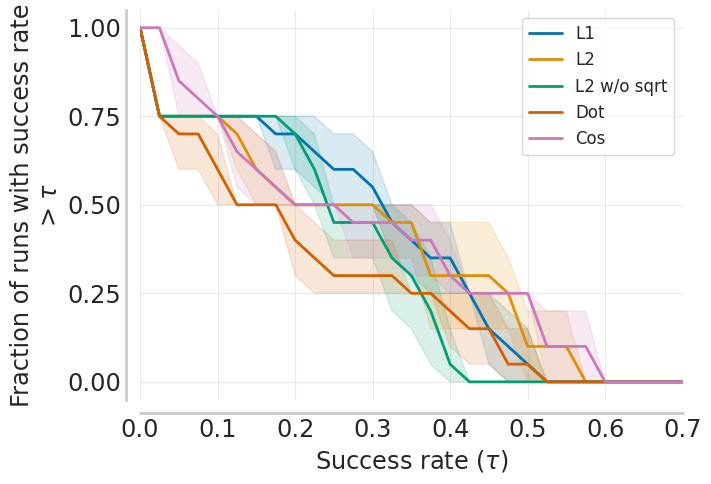

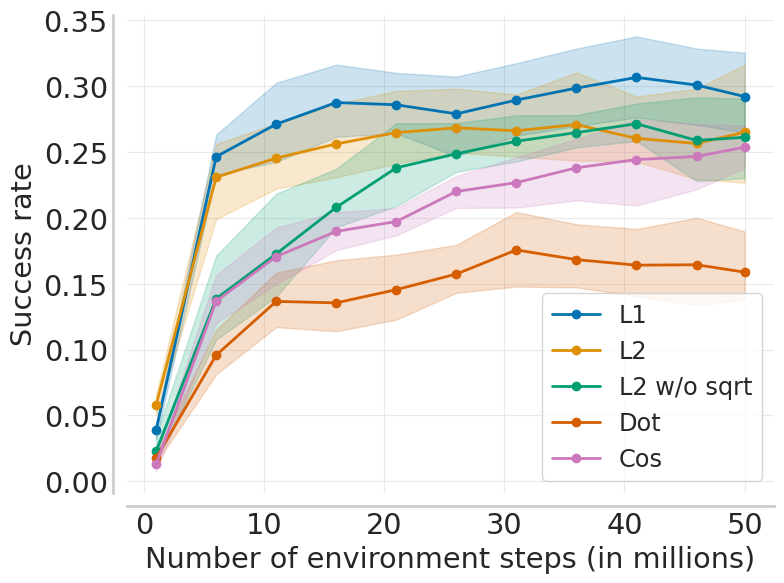

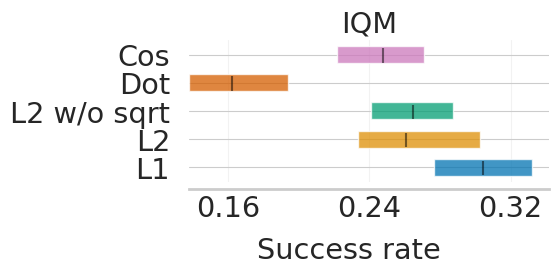

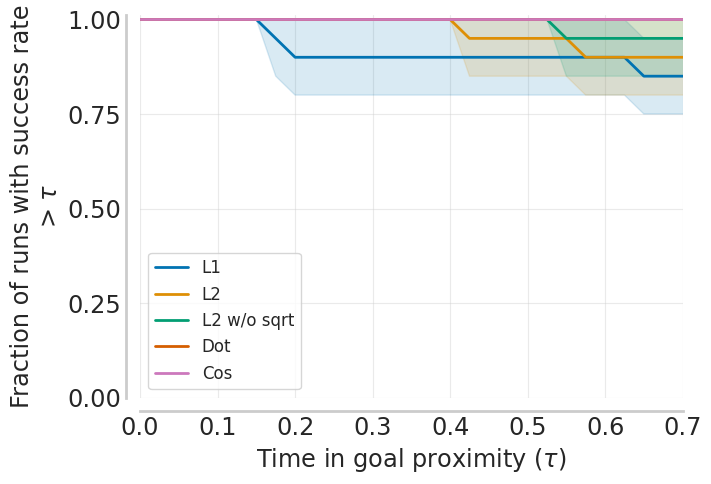

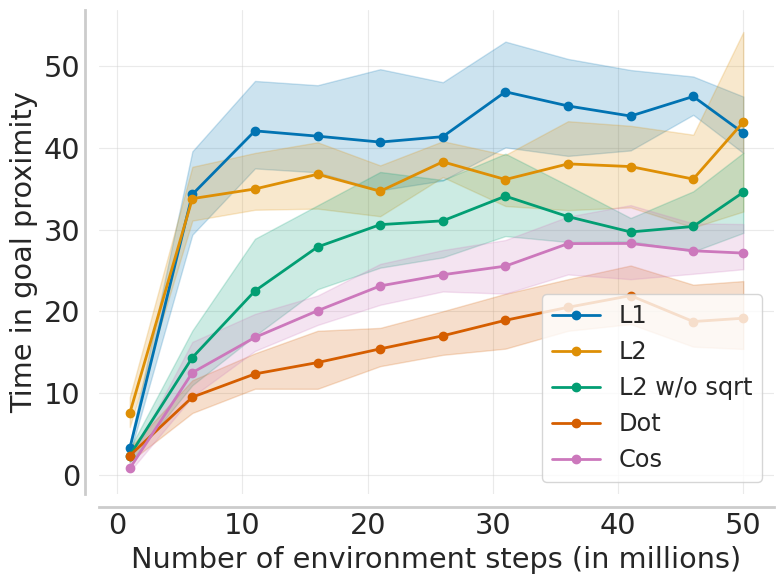

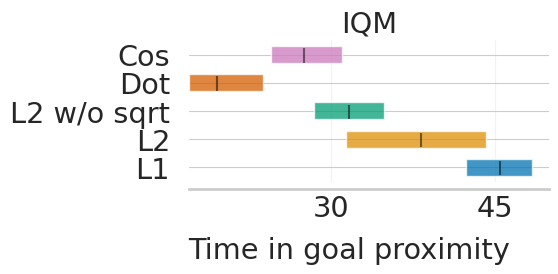

In [9]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
    )
    
    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 
    
    data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
    
    thresholds = np.linspace(0.0, 1, 41)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        data_flattened, thresholds
    )
    
    # Plot score distributions
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(list(data_flattened.keys()), sns.color_palette("colorblind"))),
        xlabel=rf"{metric_label} $(\tau)$",
        ylabel=rf"Fraction of runs with success rate > $\tau$",
        ax=ax,
        legend=True,
        legendsize="medium",
        grid_alpha=0.4, 
        figsize=(12,8),
        # use_non_linear_scaling=True
    )
    plt.xlim((0, 0.7))
    plt.tight_layout()
    plt.ylabel(rf"Fraction of runs with success rate > $\tau$", wrap=True)
    plt.savefig(os.path.join(figures_path, f"{metric_label}_performance_profile_{single_env if single_env else 'all'}.pdf"), bbox_inches="tight")
    
    
    # Sample efficiency curve
    frames = np.arange(0, 55, 5)
    frames[-1] -= 1
    ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score in data.items()}
    iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])])
    iqm_scores, iqm_cis = rly.get_interval_estimates(ale_frames_scores_dict, iqm, reps=2000)
    plot_utils.plot_sample_efficiency_curve(
        frames + 1,
        iqm_scores,
        iqm_cis,
        algorithms=list(data.keys()),
        xlabel=r"Number of environment steps (in millions)",
        ylabel=metric_label,
        legend=True,
        grid_alpha=0.4,
        figsize=(8, 6),
    )
    plt.title(f"{env_title_mapping[single_env] if single_env else ''}", fontsize="xx-large")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f"{metric_label}_{single_env if single_env else 'all'}.pdf"))
    
    
    
    aggregate_func = lambda x: np.array(
    [
        metrics.aggregate_iqm(x),
    ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        data_flattened, aggregate_func, reps=500
    )
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=["IQM"],
        algorithms=list(data.keys()),
        xlabel=f"{metric_label}",
        grid_alpha=0.4,
        max_ticks=3,
        subfigure_width=4,
        xlabel_y_coordinate=-0.3,
    )
    plt.subplots_adjust(wspace=0.2, left=0.0)
    # for ax in axes:
    #     ax.set_xlim((0.4, 0.8))
    
    
    plt.savefig(
        os.path.join(figures_path, f"{metric_label}_all_interval_estimate.pdf"), bbox_inches="tight"
    )

##  Summary

# Per env

In [10]:
metrics_ = ["eval/episode_success_any", "eval/episode_success"]

Len runs: 50
L1, ant_ball
(5, 1, 50)
L2, ant_ball
(5, 1, 50)
L2 w/o sqrt, ant_ball
(5, 1, 50)
Dot, ant_ball
(5, 1, 50)
Cos, ant_ball
(5, 1, 50)
L1, ant_ball
(5, 1, 50)
L2, ant_ball
(5, 1, 50)
L2 w/o sqrt, ant_ball
(5, 1, 50)
Dot, ant_ball
(5, 1, 50)
Cos, ant_ball
(5, 1, 50)
Len runs: 50
L1, ant
(5, 1, 50)
L2, ant
(5, 1, 50)
L2 w/o sqrt, ant
(5, 1, 50)
Dot, ant
(5, 1, 50)
Cos, ant
(5, 1, 50)
L1, ant
(5, 1, 50)
L2, ant
(5, 1, 50)
L2 w/o sqrt, ant
(5, 1, 50)
Dot, ant
(5, 1, 50)
Cos, ant
(5, 1, 50)
Len runs: 39
L1, ant_big_maze
(5, 1, 50)
L2, ant_big_maze
(5, 1, 50)
L2 w/o sqrt, ant_big_maze
(5, 1, 50)
Dot, ant_big_maze
(5, 1, 50)
Cos, ant_big_maze
(5, 1, 50)
L1, ant_big_maze
(5, 1, 50)
L2, ant_big_maze
(5, 1, 50)
L2 w/o sqrt, ant_big_maze
(5, 1, 50)
Dot, ant_big_maze
(5, 1, 50)
Cos, ant_big_maze
(5, 1, 50)
Len runs: 50
L1, ant_u_maze
(5, 1, 50)
L2, ant_u_maze
(5, 1, 50)
L2 w/o sqrt, ant_u_maze
(5, 1, 50)
Dot, ant_u_maze
(5, 1, 50)
Cos, ant_u_maze
(5, 1, 50)
L1, ant_u_maze
(5, 1, 50)
L2, a

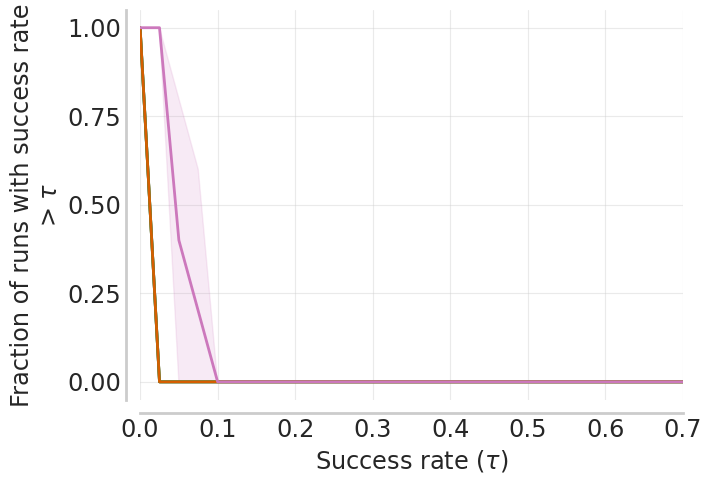

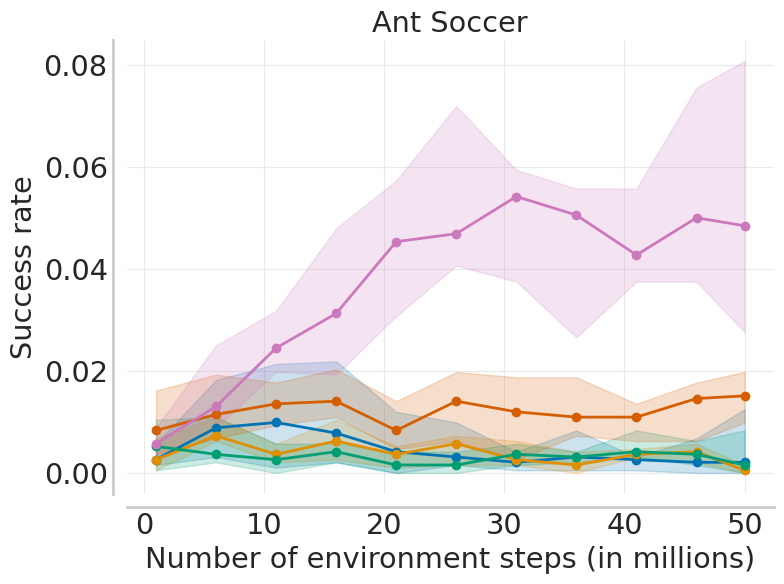

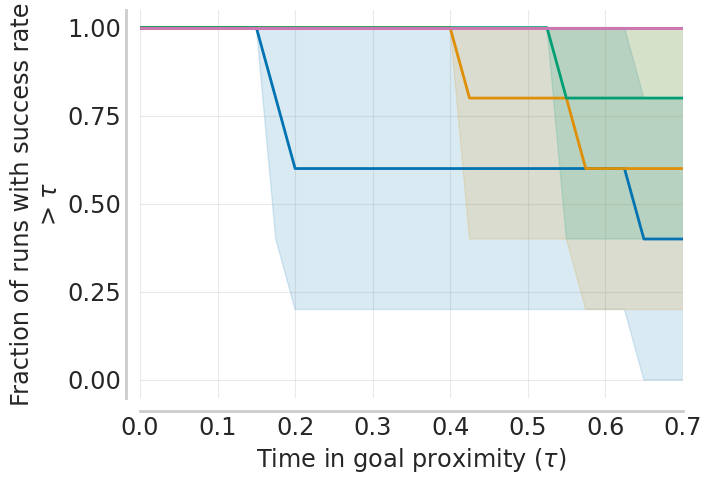

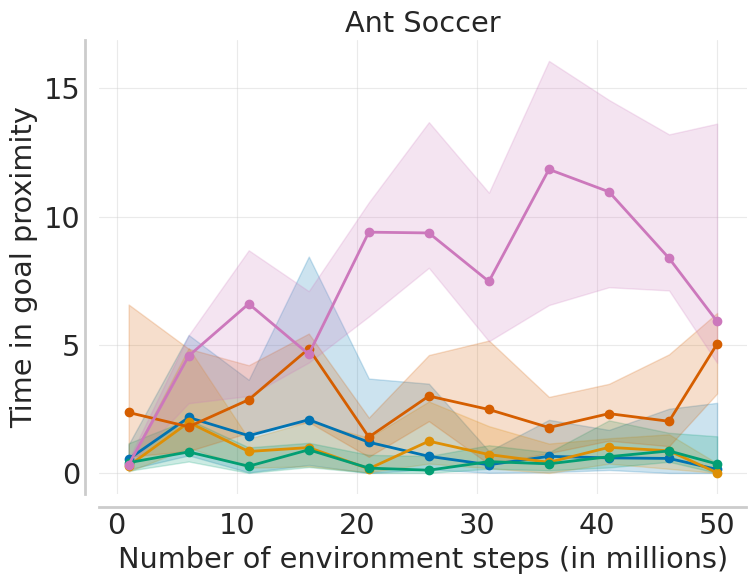

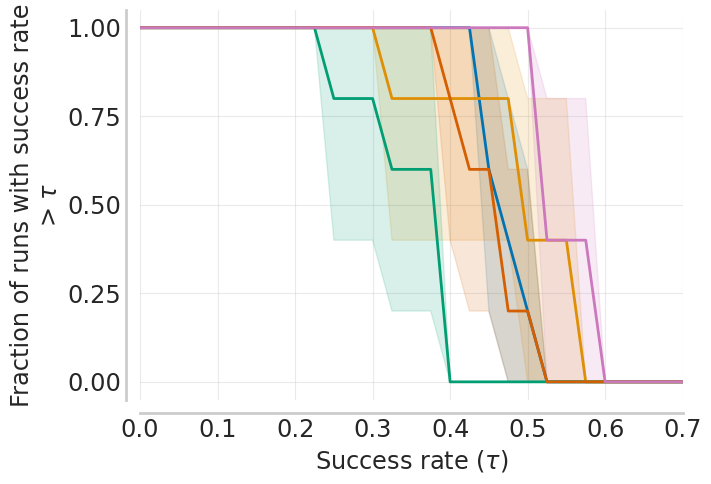

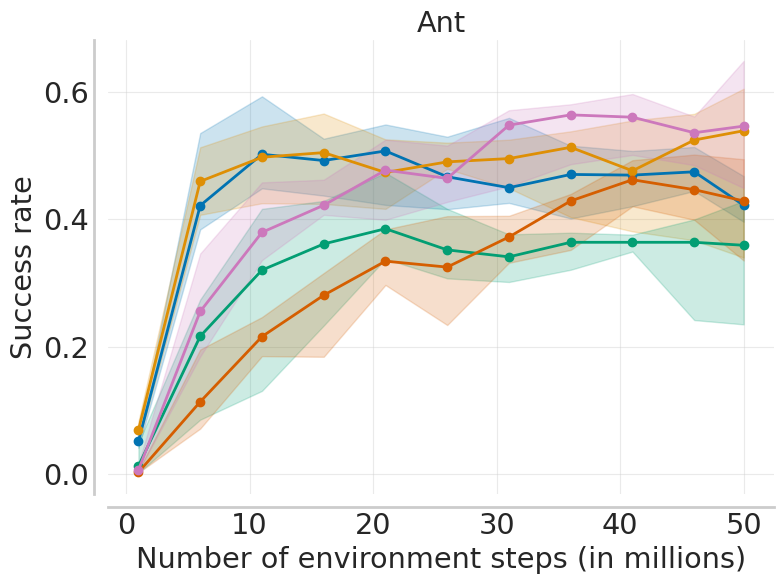

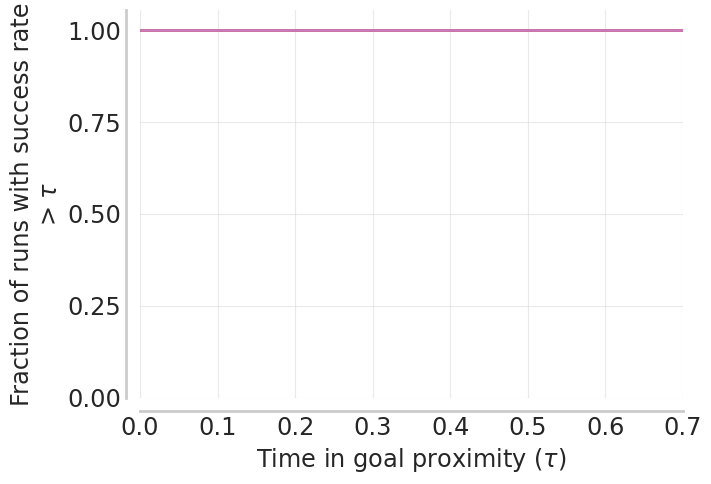

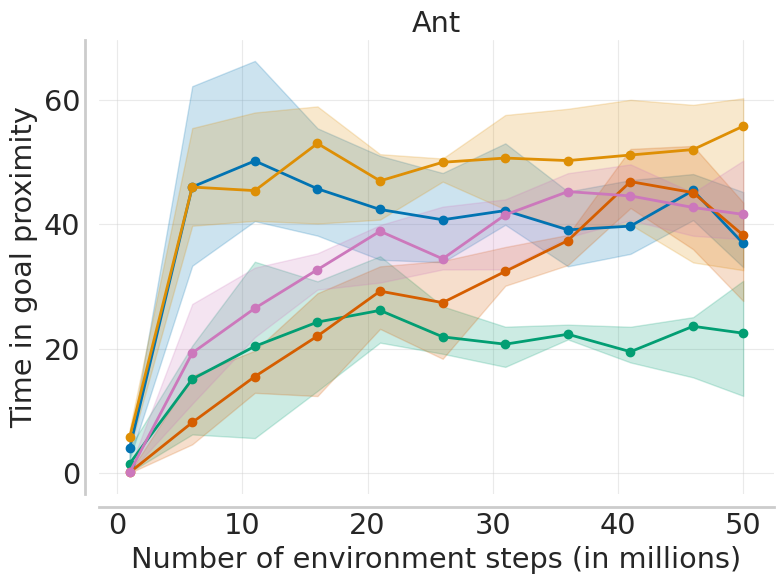

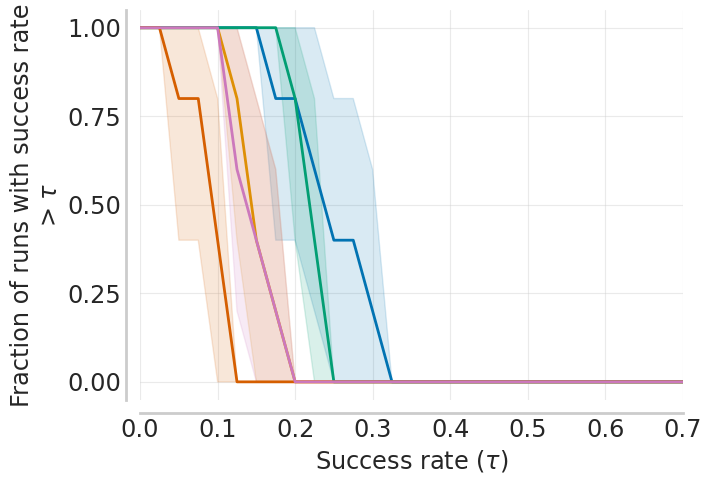

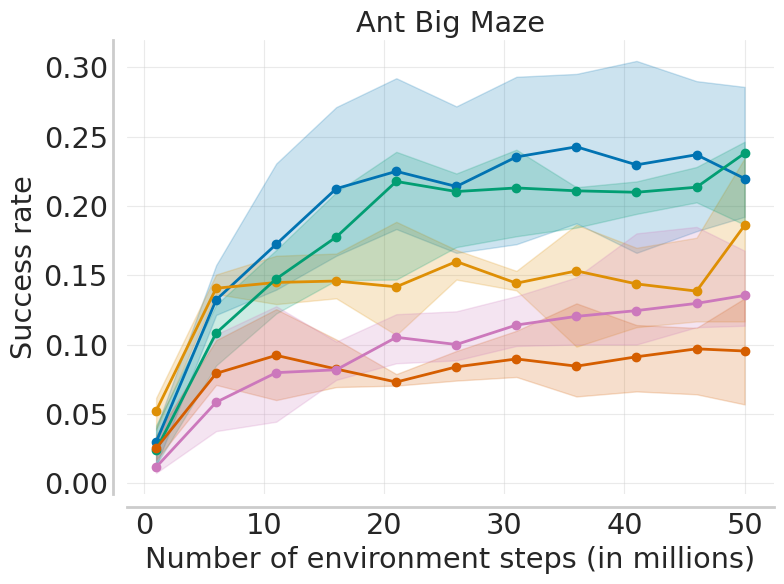

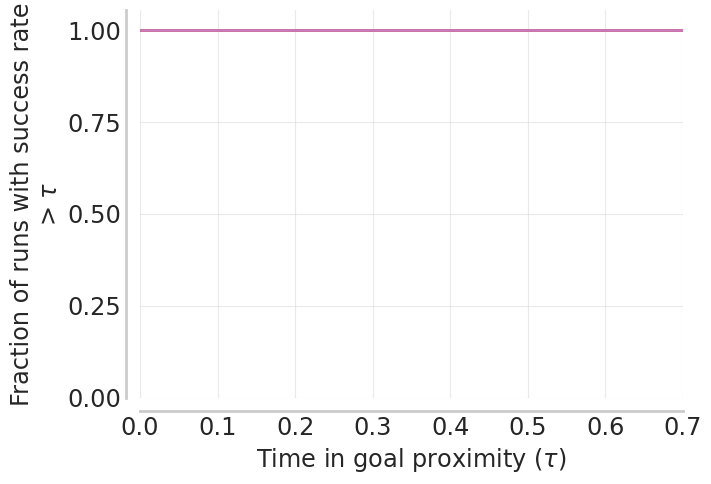

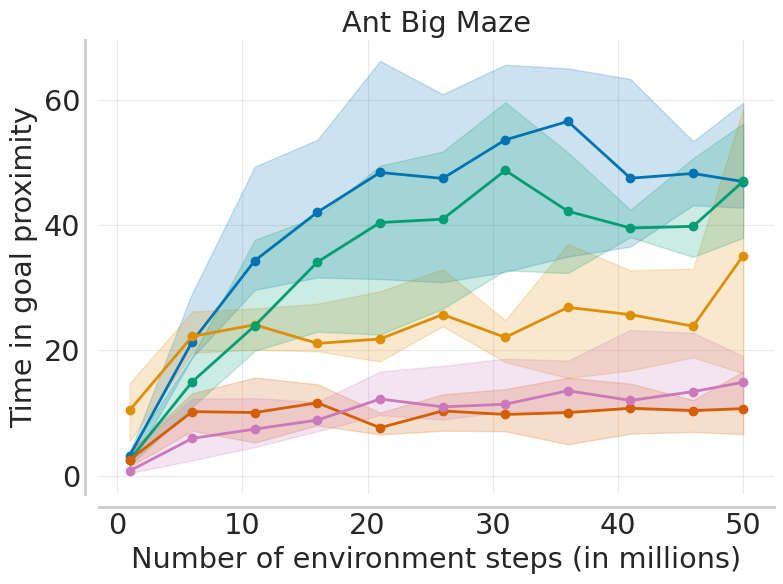

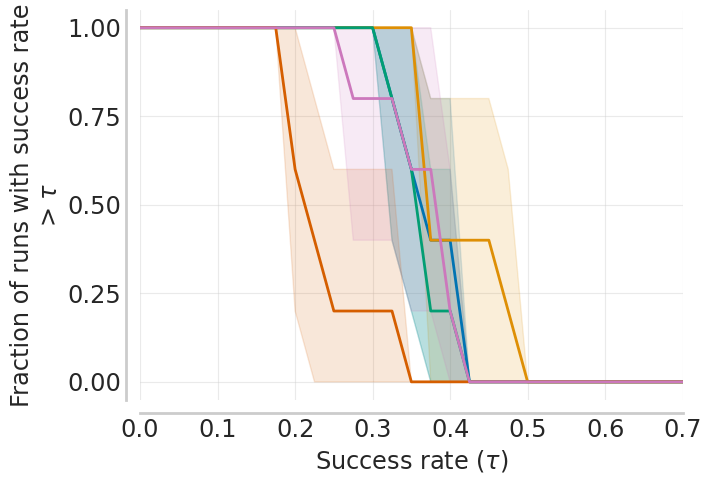

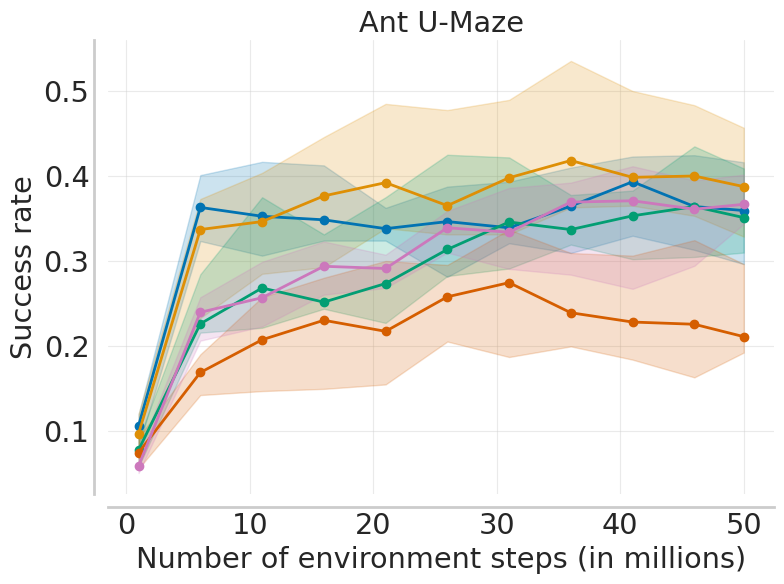

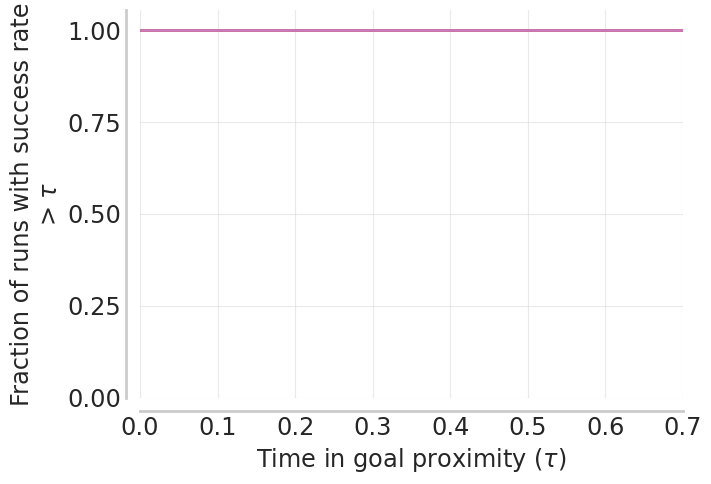

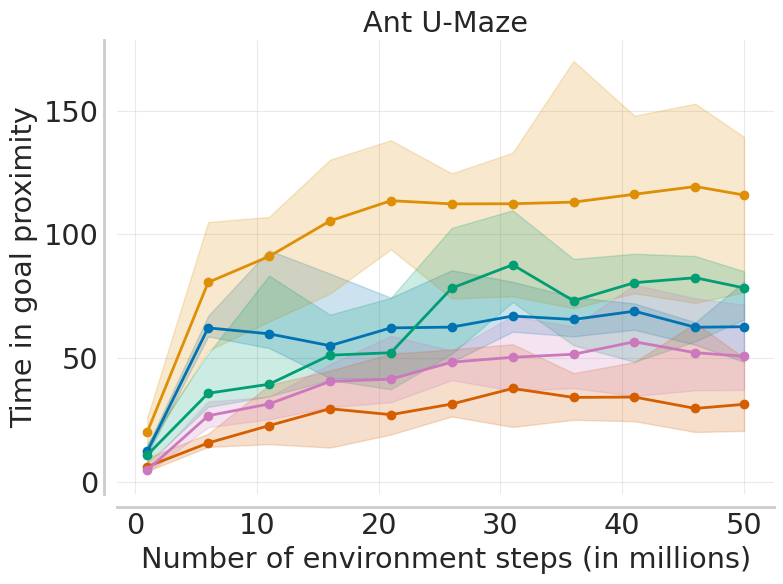

In [11]:
for env in list(env_title_mapping.keys()):
    single_env = env
    
    filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": single_env,
    "state": "finished"
    }

    # Fetch the runs from the API
    runs = api.runs(path=f"{entity}/{project}", filters=filters)
    print(f"Len runs: {len(runs)}")

    for metric in metrics_:
        metric_label = metric_to_metric_label_dict[metric]
        data = aggregate_data_from_wandb(
            runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
        )
        
        # Smoothing
        for key, item in data.items():
            data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item)
            
        data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
        
        thresholds = np.linspace(0.0, 1, 41)
        score_distributions, score_distributions_cis = rly.create_performance_profile(
            data_flattened, thresholds
        )
        # Plot score distributions
        fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
        plot_utils.plot_performance_profiles(
            score_distributions,
            thresholds,
            performance_profile_cis=score_distributions_cis,
            colors=dict(zip(list(data_flattened.keys()), sns.color_palette("colorblind"))),
            xlabel=rf"{metric_label} $(\tau)$",
            ylabel=rf"Fraction of runs with success rate > $\tau$",
            ax=ax,
            legend=False,
            legendsize="medium",
            grid_alpha=0.4, 
            figsize=(12,8),
            # use_non_linear_scaling=True
        )
        plt.xlim((0, 0.7))
        plt.tight_layout()
        plt.ylabel(rf"Fraction of runs with success rate > $\tau$", wrap=True)
        plt.savefig(os.path.join(figures_path, f"{metric_label}_performance_profile_{single_env if single_env else 'all'}.pdf"), bbox_inches="tight")
        
        
        frames = np.arange(0, 55, 5)
        frames[-1] -= 1
        ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score in data.items()}
        iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])])
        iqm_scores, iqm_cis = rly.get_interval_estimates(ale_frames_scores_dict, iqm, reps=2000)
        plot_utils.plot_sample_efficiency_curve(
            frames + 1,
            iqm_scores,
            iqm_cis,
            algorithms=list(data.keys()),
            xlabel=r"Number of environment steps (in millions)",
            ylabel=metric_label,
            legend=False,
            grid_alpha=0.4,
            figsize=(8, 6),
        )
        plt.title(f"{env_title_mapping[single_env] if single_env else ''}", fontsize="xx-large")
        plt.tight_layout()
        plt.savefig(os.path.join(figures_path, f"{metric_label}_{single_env if single_env else 'all'}.pdf"))